# Building Footprint Extraction from COCO Annotations

This notebook extracts building footprints from a COCO format annotation file that contains both polygon and RLE format annotations. The footprints are saved as binary masks in the specified output folder.

In [56]:
import json
import os
import numpy as np
import cv2
from shapely.geometry import Polygon
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
import pandas as pd
from collections import Counter, defaultdict
from datetime import datetime

## Configuration Parameters

In [57]:
# Define relative paths - uses the current working directory as base
# Get the current working directory
current_dir = os.path.abspath(os.path.dirname(''))

# Define paths relative to the current directory
# Create JSON and statistics directories if they don't exist
JSON_DIR = os.path.join(current_dir, "JSON")
os.makedirs(JSON_DIR, exist_ok=True)

COCO_PATH = os.path.join(JSON_DIR, "buildings_only_train.json")
OUTPUT_DIR = os.path.join(current_dir, "train", "sem")
DSM_FOLDER = os.path.join(current_dir, "train", "dsm")

# Statistics output paths
STATS_DIR = os.path.join(current_dir, "statistics")
os.makedirs(STATS_DIR, exist_ok=True)
STATS_FILE = os.path.join(STATS_DIR, f"building_stats_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Print paths for verification
print(f"COCO annotation file: {COCO_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"DSM folder: {DSM_FOLDER}")
print(f"Statistics output: {STATS_FILE}")

COCO annotation file: c:\Users\Ahmad\Desktop\Ozyegin University\research\datasets\DFC2023C\JSON\buildings_only_train.json
Output directory: c:\Users\Ahmad\Desktop\Ozyegin University\research\datasets\DFC2023C\train\sem
DSM folder: c:\Users\Ahmad\Desktop\Ozyegin University\research\datasets\DFC2023C\train\dsm
Statistics output: c:\Users\Ahmad\Desktop\Ozyegin University\research\datasets\DFC2023C\statistics\building_stats_20250406_122948.md


## Statistics Tracking Variables

In [58]:
# Initialize counters for statistics
stats = {
    'total_images': 0,
    'images_with_footprints': 0,
    'total_footprints': 0,
    'invalid_polygon_footprints': 0,
    'zero_height_buildings': 0,
    'valid_buildings': 0,
    'images_with_valid_buildings': set(),
    'images_with_zero_height_buildings': set(),
    'images_with_invalid_polygons': set(),
    'images_with_mixed_types': set(),
    'footprint_types_per_image': defaultdict(lambda: {'valid': 0, 'zero_height': 0, 'invalid': 0})
}

# Function to validate polygon geometry
def is_valid_polygon(polygon):
    """Check if a polygon is geometrically valid using the same criteria as process_annotations.py."""
    if not polygon or len(polygon) < 6:  # At least 3 points (x,y pairs)
        return False
        
    try:
        # Just check if a Shapely polygon can be created
        # Don't use the stricter shapely_poly.is_valid check
        points = np.array(polygon).reshape(-1, 2)
        p = Polygon(points)
        return True  # If we can create the polygon without exception, consider it valid
    except Exception as e:
        print(f"Error validating polygon: {e}")
        return False

# Function to get building height from DSM
def get_building_height(footprint, image_info, dsm_folder):
    """Calculate average height of a building using DSM data."""
    # Get image filename and create DSM path
    img_filename = os.path.splitext(image_info['file_name'])[0]
    dsm_path = os.path.join(dsm_folder, f"{img_filename}.tif")
    
    # Skip if DSM file doesn't exist
    if not os.path.exists(dsm_path):
        return None
        
    # Get segmentation data
    if 'segmentation' not in footprint:
        return None
        
    segmentation = footprint['segmentation']
    height, width = image_info['height'], image_info['width']
    
    # Create a mask for the building
    mask = process_footprint(footprint, image_info)
    
    # Open DSM file and read height values
    try:
        with rasterio.open(dsm_path) as dsm:
            dsm_data = dsm.read(1)  # Read the first band
            
            # Apply mask to get height values only for the building
            building_heights = dsm_data[mask > 0]
            
            if len(building_heights) > 0:
                avg_height = np.mean(building_heights)
                return avg_height
            else:
                return 0  # No height data for the building
    except Exception as e:
        print(f"Error reading DSM for {img_filename}: {e}")
        return None

## Helper Functions for Handling Polygons and RLE

In [59]:
def decode_rle(rle, shape):
    """
    Decode RLE format to binary mask.
    
    Args:
        rle (dict): COCO RLE format with 'counts' and 'size' keys
        shape (tuple): Shape of the output mask (height, width)
        
    Returns:
        np.ndarray: Binary mask
    """
    if isinstance(rle['counts'], list):
        # Handle uncompressed RLE format
        mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
        counts = rle['counts']
        pos = 0
        for i, count in enumerate(counts):
            val = i % 2  # 0, 1, 0, 1, ...
            mask[pos:pos+count] = val
            pos += count
        return mask.reshape(shape)
    else:
        # Handle compressed RLE format using pycocotools if possible
        try:
            from pycocotools import mask as coco_mask
            return coco_mask.decode(rle).astype(np.uint8)
        except ImportError:
            print("Warning: pycocotools not available, using fallback RLE decoder")
            # Fallback for compressed RLE - this is a simple implementation
            # May not be efficient for all cases
            import zlib
            # Make sure numpy is available in this scope
            # (the original error was due to np being out of scope in this except block)
            import numpy  # Import again to ensure it's available in this scope
            from itertools import groupby
            
            if isinstance(rle['counts'], bytes):
                # Decompress if the counts are compressed
                rle_counts = zlib.decompress(rle['counts']).decode('ascii')
            else:
                rle_counts = rle['counts']
                
            counts = [int(x) for x in rle_counts.split()]
            mask = numpy.zeros(shape[0] * shape[1], dtype=numpy.uint8)
            start = 0
            for i, count in enumerate(counts):
                val = i % 2
                end = start + count
                mask[start:end] = val
                start = end
            return mask.reshape(shape)

In [60]:
def polygon_to_mask(polygons, height, width):
    """
    Convert polygon segmentation to binary mask.
    
    Args:
        polygons (list): List of polygon coordinates in COCO format
        height (int): Height of the mask
        width (int): Width of the mask
        
    Returns:
        np.ndarray: Binary mask
    """
    mask = np.zeros((height, width), dtype=np.uint8)
    
    for polygon in polygons:
        # Check if the polygon is valid
        if len(polygon) < 6:  # At least 3 points (x,y pairs)
            continue
            
        # Reshape polygon to a format that OpenCV can process
        try:
            poly_array = np.array(polygon).reshape(-1, 2).astype(np.int32)
            cv2.fillPoly(mask, [poly_array], 1)
        except Exception as e:
            print(f"Error processing polygon: {e}")
            continue
    
    return mask

In [61]:
def process_footprint(footprint, image_info):
    """
    Process a single building footprint to create a binary mask.
    
    Args:
        footprint (dict): COCO annotation object representing a building footprint
        image_info (dict): COCO image information
        
    Returns:
        np.ndarray: Binary mask for the building footprint
    """
    height, width = image_info['height'], image_info['width']
    
    # Check if the footprint has segmentation
    if 'segmentation' not in footprint:
        return np.zeros((height, width), dtype=np.uint8)
    
    segmentation = footprint['segmentation']
    
    # Handle different segmentation formats
    if isinstance(segmentation, dict) and 'counts' in segmentation:
        # RLE format
        return decode_rle(segmentation, (height, width))
    elif isinstance(segmentation, list):
        if len(segmentation) > 0:
            if isinstance(segmentation[0], list):
                # Polygon format
                return polygon_to_mask(segmentation, height, width)
            elif isinstance(segmentation[0], dict) and 'counts' in segmentation[0]:
                # List of RLE format
                mask = np.zeros((height, width), dtype=np.uint8)
                for rle in segmentation:
                    mask = np.logical_or(mask, decode_rle(rle, (height, width)))
                return mask.astype(np.uint8)
    
    # Default case - empty mask
    return np.zeros((height, width), dtype=np.uint8)

## Load and Process COCO Building Footprints

In [62]:
# Load COCO building footprints
print(f"Loading building footprints from {COCO_PATH}...")
with open(COCO_PATH, 'r') as f:
    coco_data = json.load(f)

# Update statistics
stats['total_images'] = len(coco_data['images'])
stats['total_footprints'] = len(coco_data['annotations'])

# Create image_id to image_info mapping
image_info_map = {image['id']: image for image in coco_data['images']}

# Group footprints by image_id
footprints_by_image = {}
for footprint in coco_data['annotations']:
    image_id = footprint['image_id']
    if image_id not in footprints_by_image:
        footprints_by_image[image_id] = []
    footprints_by_image[image_id].append(footprint)

# Count images with footprints
stats['images_with_footprints'] = len(footprints_by_image)

print(f"Found {stats['total_images']} images and {stats['total_footprints']} building footprints")
print(f"Images with building footprints: {stats['images_with_footprints']}")

Loading building footprints from c:\Users\Ahmad\Desktop\Ozyegin University\research\datasets\DFC2023C\JSON\buildings_only_train.json...
Found 1773 images and 125153 building footprints
Images with building footprints: 1770
Found 1773 images and 125153 building footprints
Images with building footprints: 1770


## Analyze Building Footprint Quality

In [63]:
# Analyze building footprint quality
print("Analyzing building footprint quality...")

# Initialize counters for polygon segments
total_polygons = 0

for image_id, footprints in tqdm(footprints_by_image.items(), desc="Analyzing footprints"):
    image_info = image_info_map[image_id]
    image_has_valid = False
    image_has_zero_height = False
    image_has_invalid = False
    
    for footprint in footprints:
        # Check if this is a building footprint
        if footprint.get('category_id', 1) == 1:
            # Get segmentation data
            if 'segmentation' not in footprint:
                continue
                
            segmentation = footprint['segmentation']
            is_invalid = False
            is_rle_format = False
            
            # Count actual polygon objects (not just coordinate lists)
            if isinstance(segmentation, dict) and 'counts' in segmentation:
                # RLE format - counts as 1 polygon
                is_rle_format = True
                total_polygons += 1
                # For RLE, we'll check if decoding works in a try-except
                try:
                    # Try to decode the RLE - this will throw an exception if invalid
                    mask = decode_rle(segmentation, (image_info['height'], image_info['width']))
                    # If we get here, RLE decoding succeeded
                except Exception as e:
                    print(f"Error decoding RLE: {e}")
                    is_invalid = True
            elif isinstance(segmentation, list) and len(segmentation) > 0:
                if isinstance(segmentation[0], list):
                    # Polygon format - count each list as one polygon/part
                    total_polygons += len(segmentation)
                    # Check each polygon in the list
                    for poly in segmentation:
                        if not is_valid_polygon(poly):
                            is_invalid = True
                            break
                elif isinstance(segmentation[0], dict) and 'counts' in segmentation[0]:
                    # List of RLE format - count each as one polygon/part
                    is_rle_format = True
                    total_polygons += len(segmentation)
                    # Check if all RLEs can be decoded
                    try:
                        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
                        for rle in segmentation:
                            # Try to decode each RLE
                            rle_mask = decode_rle(rle, (image_info['height'], image_info['width']))
                            mask = np.logical_or(mask, rle_mask).astype(np.uint8)
                        # If we get here, all RLEs decoded successfully
                    except Exception as e:
                        print(f"Error decoding RLE list: {e}")
                        is_invalid = True
                else:
                    # Unknown format
                    is_invalid = True
            else:
                # Empty or invalid segmentation format
                is_invalid = True
            
            # Get building height
            height = get_building_height(footprint, image_info, DSM_FOLDER)
            # Use np.isclose() to match the criteria in process_annotations.py
            is_zero_height = height is not None and np.isclose(height, 0)
            
            # Update statistics
            if is_invalid:
                stats['invalid_polygon_footprints'] += 1
                image_has_invalid = True
                stats['footprint_types_per_image'][image_id]['invalid'] += 1
            elif is_zero_height:
                stats['zero_height_buildings'] += 1
                image_has_zero_height = True
                stats['footprint_types_per_image'][image_id]['zero_height'] += 1
            else:
                stats['valid_buildings'] += 1
                image_has_valid = True
                stats['footprint_types_per_image'][image_id]['valid'] += 1
    
    # Update image-level statistics
    if image_has_valid:
        stats['images_with_valid_buildings'].add(image_id)
    if image_has_zero_height:
        stats['images_with_zero_height_buildings'].add(image_id)
    if image_has_invalid:
        stats['images_with_invalid_polygons'].add(image_id)
        
    # Check if this image has mixed footprint types
    footprint_types_count = sum(1 for val in ['valid', 'zero_height', 'invalid'] 
                               if stats['footprint_types_per_image'][image_id][val] > 0)
    if footprint_types_count >= 2:
        stats['images_with_mixed_types'].add(image_id)

# Print summary statistics
print("\nBuilding Footprint Quality Summary:")
print(f"Valid building footprints: {stats['valid_buildings']} ({stats['valid_buildings']/stats['total_footprints']*100:.1f}% of all footprints)")
print(f"Zero-height building footprints: {stats['zero_height_buildings']} ({stats['zero_height_buildings']/stats['total_footprints']*100:.1f}% of all footprints)")
print(f"Invalid building footprints: {stats['invalid_polygon_footprints']} ({stats['invalid_polygon_footprints']/stats['total_footprints']*100:.1f}% of all footprints)")
print(f"\nTotal building footprints: {stats['total_footprints']}")
print(f"Total polygons in footprints: {total_polygons}")
print(f"Difference (polygons - footprints): {total_polygons - stats['total_footprints']}")
print(f"\nImages with valid footprints: {len(stats['images_with_valid_buildings'])} ({len(stats['images_with_valid_buildings'])/stats['total_images']*100:.1f}% of all images)")
print(f"Images with zero-height footprints: {len(stats['images_with_zero_height_buildings'])} ({len(stats['images_with_zero_height_buildings'])/stats['total_images']*100:.1f}% of all images)")
print(f"Images with invalid footprints: {len(stats['images_with_invalid_polygons'])} ({len(stats['images_with_invalid_polygons'])/stats['total_images']*100:.1f}% of all images)")
print(f"Images with mixed footprint types: {len(stats['images_with_mixed_types'])} ({len(stats['images_with_mixed_types'])/stats['total_images']*100:.1f}% of all images)")

Analyzing building footprint quality...


Analyzing footprints:   0%|          | 0/1770 [00:00<?, ?it/s]


Building Footprint Quality Summary:
Valid building footprints: 116090 (92.8% of all footprints)
Zero-height building footprints: 9063 (7.2% of all footprints)
Invalid building footprints: 0 (0.0% of all footprints)

Total building footprints: 125153
Total polygons in footprints: 125774
Difference (polygons - footprints): 621

Images with valid footprints: 1769 (99.8% of all images)
Images with zero-height footprints: 1509 (85.1% of all images)
Images with invalid footprints: 0 (0.0% of all images)
Images with mixed footprint types: 1508 (85.1% of all images)


## Generate Building Footprints

In [64]:
# Process each image and save the building footprints
print(f"Generating building footprints and saving to {OUTPUT_DIR}...")

for image_id, image_info in tqdm(image_info_map.items(), desc="Processing images"):
    # Get image file name without extension for saving
    filename = os.path.splitext(image_info['file_name'])[0]
    
    # Get all footprints for this image
    footprints = footprints_by_image.get(image_id, [])
    
    # If no footprints, create an empty mask
    if not footprints:
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    else:
        # Process all footprints for this image
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        for footprint in footprints:
            # Check if this is a building (category_id=1 typically represents buildings)
            # You may need to adjust this based on your dataset
            if footprint.get('category_id', 1) == 1:
                footprint_mask = process_footprint(footprint, image_info)
                mask = np.logical_or(mask, footprint_mask).astype(np.uint8)
    
    # Scale mask values to 0-255 for better visualization if needed
    mask = mask * 255
    
    # Save mask
    output_path = os.path.join(OUTPUT_DIR, f"{filename}.png")
    cv2.imwrite(output_path, mask)

print("All building footprints have been processed and saved!")

Generating building footprints and saving to c:\Users\Ahmad\Desktop\Ozyegin University\research\datasets\DFC2023C\train\sem...


Processing images:   0%|          | 0/1773 [00:00<?, ?it/s]

All building footprints have been processed and saved!


## Save Statistics to File

In [65]:
# Save statistics to a markdown file
print(f"Saving statistics to {STATS_FILE}...")

with open(STATS_FILE, 'w') as f:
    f.write("# DFC2023 Dataset Building Footprint Statistics\n\n")
    f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("## Dataset Overview\n\n")
    f.write(f"- Total samples: {stats['total_images']}\n")
    f.write(f"- Total building footprints: {stats['total_footprints']}\n")
    f.write(f"- Total polygons in footprints: {total_polygons}\n")
    f.write(f"- Difference (polygons - footprints): {total_polygons - stats['total_footprints']}\n")
    f.write(f"- Images with footprints: {stats['images_with_footprints']} ({stats['images_with_footprints']/stats['total_images']*100:.1f}% of all images)\n\n")
    
    f.write("## Building Footprint Quality\n\n")
    f.write("### Building Footprint Distribution:\n")
    f.write(f"- Total building footprints: {stats['total_footprints']} (100.0%)\n")
    f.write(f"- Valid building footprints: {stats['valid_buildings']} ({stats['valid_buildings']/stats['total_footprints']*100:.1f}% of all footprints)\n")
    f.write(f"- Zero-height building footprints: {stats['zero_height_buildings']} ({stats['zero_height_buildings']/stats['total_footprints']*100:.1f}% of all footprints)\n")
    f.write(f"- Invalid building footprints: {stats['invalid_polygon_footprints']} ({stats['invalid_polygon_footprints']/stats['total_footprints']*100:.1f}% of all footprints)\n\n")
    
    f.write("### Sample Distribution:\n")
    f.write(f"- Images in COCO file: {stats['total_images']} (100.0%)\n")
    f.write(f"- Images with any footprints: {stats['images_with_footprints']} ({stats['images_with_footprints']/stats['total_images']*100:.1f}% of all images)\n")
    f.write(f"- Images with valid footprints: {len(stats['images_with_valid_buildings'])} ({len(stats['images_with_valid_buildings'])/stats['total_images']*100:.1f}% of all images)\n")
    f.write(f"- Images with zero-height footprints: {len(stats['images_with_zero_height_buildings'])} ({len(stats['images_with_zero_height_buildings'])/stats['total_images']*100:.1f}% of all images)\n")
    f.write(f"- Images with invalid footprints: {len(stats['images_with_invalid_polygons'])} ({len(stats['images_with_invalid_polygons'])/stats['total_images']*100:.1f}% of all images)\n")
    f.write(f"- Images with mixed footprint types: {len(stats['images_with_mixed_types'])} ({len(stats['images_with_mixed_types'])/stats['total_images']*100:.1f}% of all images)\n")

print(f"Statistics saved to {STATS_FILE}")

Saving statistics to c:\Users\Ahmad\Desktop\Ozyegin University\research\datasets\DFC2023C\statistics\building_stats_20250406_122948.md...
Statistics saved to c:\Users\Ahmad\Desktop\Ozyegin University\research\datasets\DFC2023C\statistics\building_stats_20250406_122948.md


## Visualize Example Results

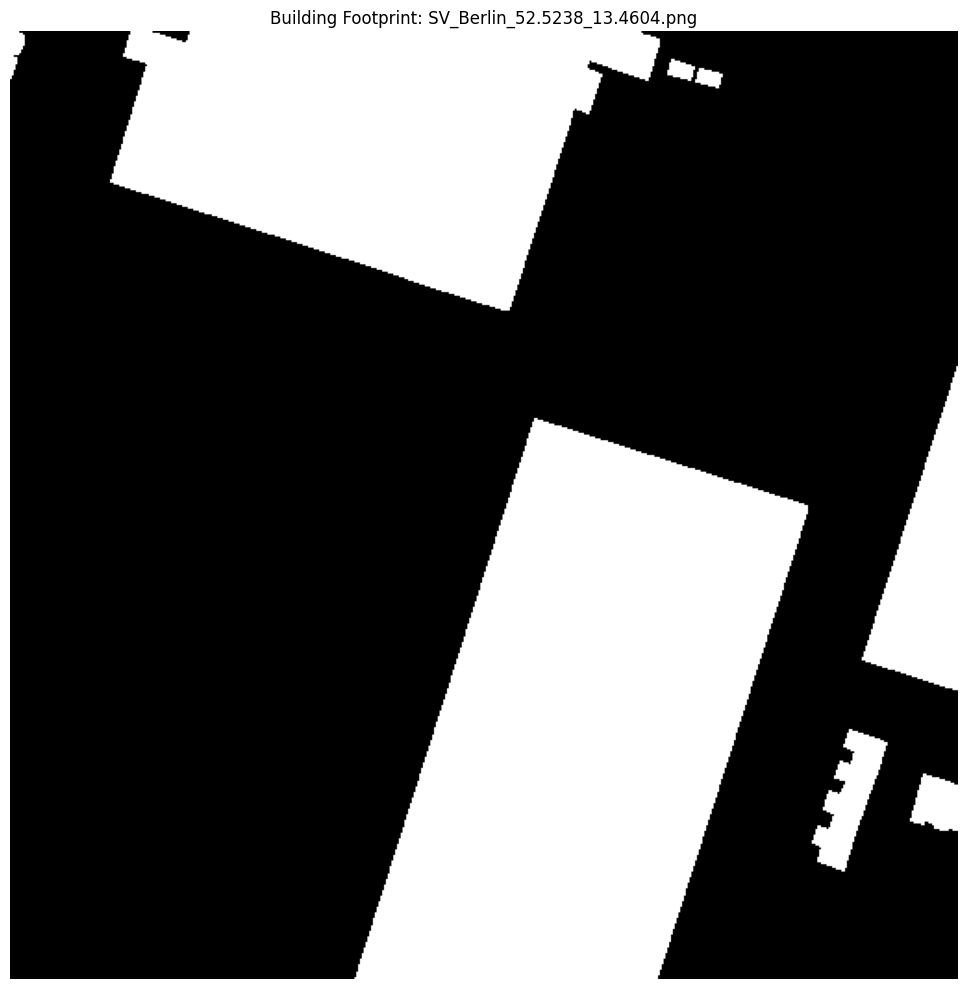

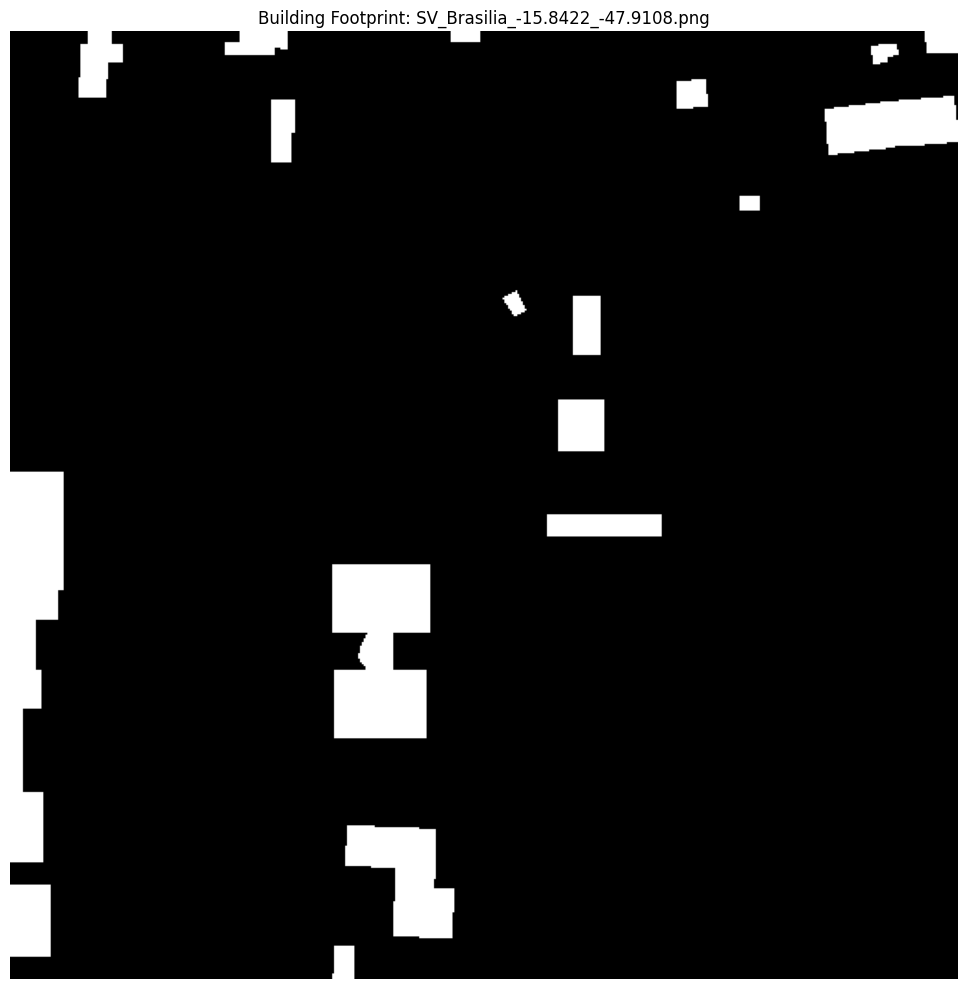

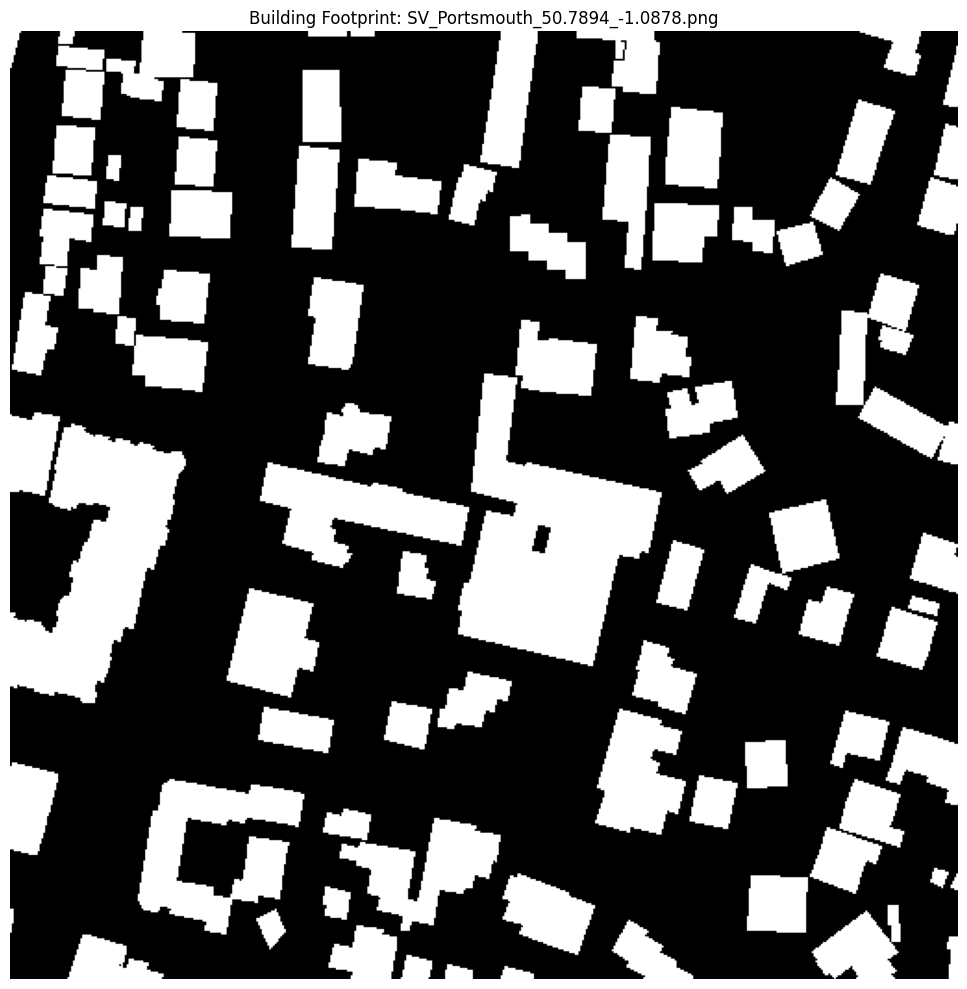

In [66]:
# Choose a few random images to visualize
import random

def visualize_footprint(mask_path):
    """
    Visualize a building footprint mask.
    
    Args:
        mask_path (str): Path to the mask file
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap='gray')
    plt.title(f"Building Footprint: {os.path.basename(mask_path)}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get list of generated masks
mask_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')]

# Visualize a few random examples (if any masks were generated)
if mask_files:
    num_examples = min(3, len(mask_files))
    for mask_file in random.sample(mask_files, num_examples):
        visualize_footprint(os.path.join(OUTPUT_DIR, mask_file))
else:
    print("No mask files were generated.")